# Peaks detection and features measurment

---

In [1]:
import os
import glob
import logging
import time

import matplotlib.pyplot as plt
import plotly.express as px

import numpy as np
import pandas as pd

import scipy
from scipy import signal
from scipy import stats
from scipy import ndimage

from sklearn import preprocessing

## Preprocessing

#### Data uploading and scaling

In [10]:
total_df = pd.read_csv('ctrl_data/f_7_output_df.csv')
print(total_df.head())


# https://stackoverflow.com/questions/66399486/how-to-find-out-peak-rise-and-decay

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

def norm_profiles_to_arr(input_df):
    """ Normilize Ca profiles in 0-1 range
    Return: np array [component, raw_profile, norm_profile]
    """
    output_arr = []
    comp_list = np.array(total_df.comp.unique())
    for comp in comp_list:
        comp_profile_raw = np.array(input_df['profile_raw'][input_df['comp'] == comp])
        # comp_profile_norm = (comp_profile_raw-np.min(comp_profile_raw)) / (np.max(comp_profile_raw) - np.min(comp_profile_raw))  # custom func
        comp_profile_norm = preprocessing.minmax_scale(comp_profile_raw)
        output_arr.append([comp_profile_raw, comp_profile_norm])
    return np.asarray(output_arr)


norm_profiles = norm_profiles_to_arr(total_df)

# raw profiles view
fig=px.line(total_df,
            y='profile_raw',
            x='time',
            color='comp',
            animation_frame="comp",
            title='Individual components raw profiles')
fig.update(layout_yaxis_range = [min(total_df.profile_raw), 300])
fig.show()

  reg_name     time  comp  profile_raw   profile_C  profile_ddf
0      F_7  0.00000     0   259.270382 -476.772454          0.0
1      F_7  1.09006     0   244.467578 -476.772454          0.0
2      F_7  2.18012     0   241.532513 -476.772454          0.0
3      F_7  3.27018     0   255.757959 -476.772454          0.0
4      F_7  4.36024     0   255.835385 -476.772454          0.0


#### Sample global parameters, detection & measurment options

In [4]:
# global sample options
total_reg_t = 1634
frame_time = total_reg_t / norm_profiles.shape[-1]

app_start_t = 256
app_end_t = 628
reg_name = 'E_0002'

time_line = np.linspace(0, total_reg_t, num=norm_profiles.shape[-1])
app_line = np.linspace(app_start_t, app_end_t)


# detection options
min_distance_sec = 3
min_distance_frames = int(min_distance_sec / frame_time)
if min_distance_frames < 1:
    min_distance_frames = 1

width_sec = [1, 200]  # [min, max]
width_frames = np.asanyarray([width_sec[0]/frame_time, width_sec[1]/frame_time], dtype=int)  # [min, max]

plat_sec = [1, 500]  # [min, max]
plat_frames = np.asarray([plat_sec[0]/frame_time, plat_sec[1]/frame_time], dtype=int)
plat_frames[plat_frames == 0] = 1

# ΔF/F options
delta_win_shift = 0
delta_win_size = 10


#### Ctrl. profiles plot

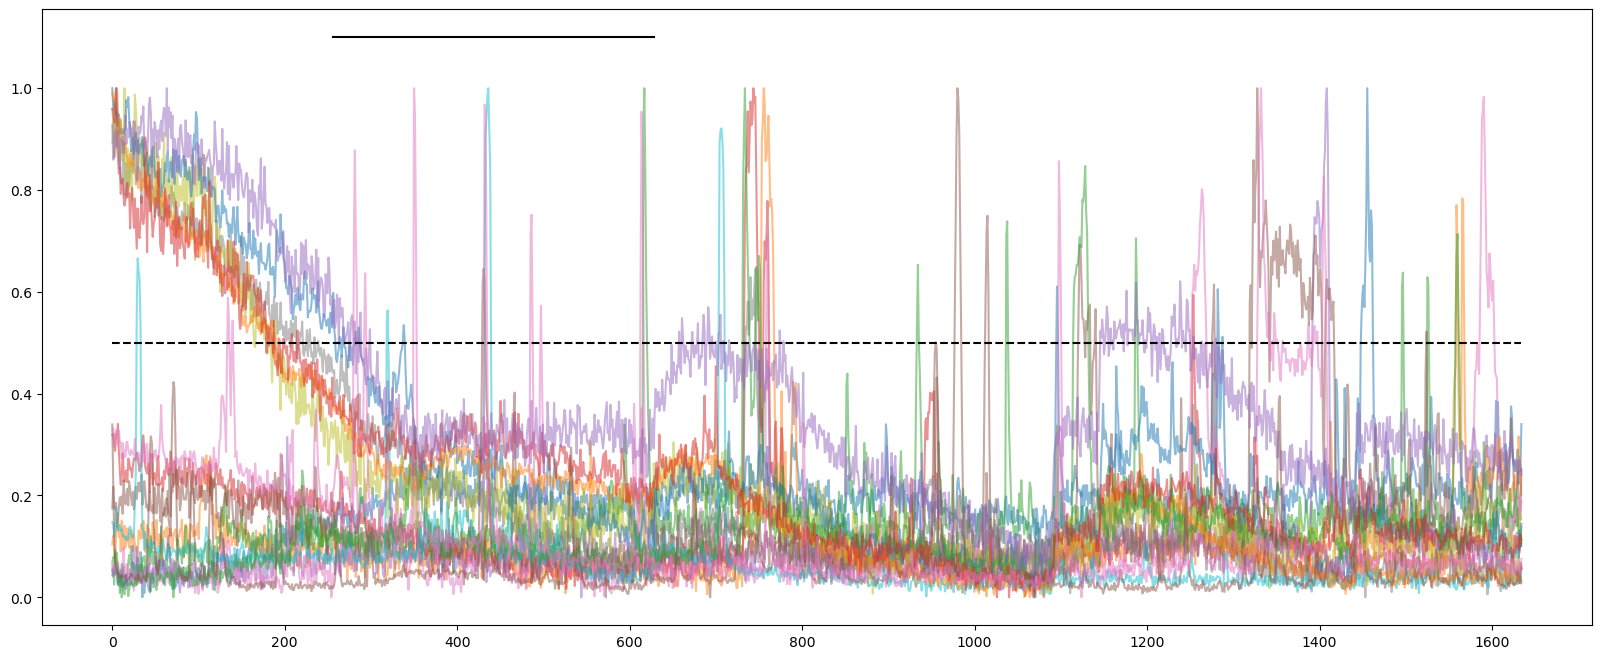

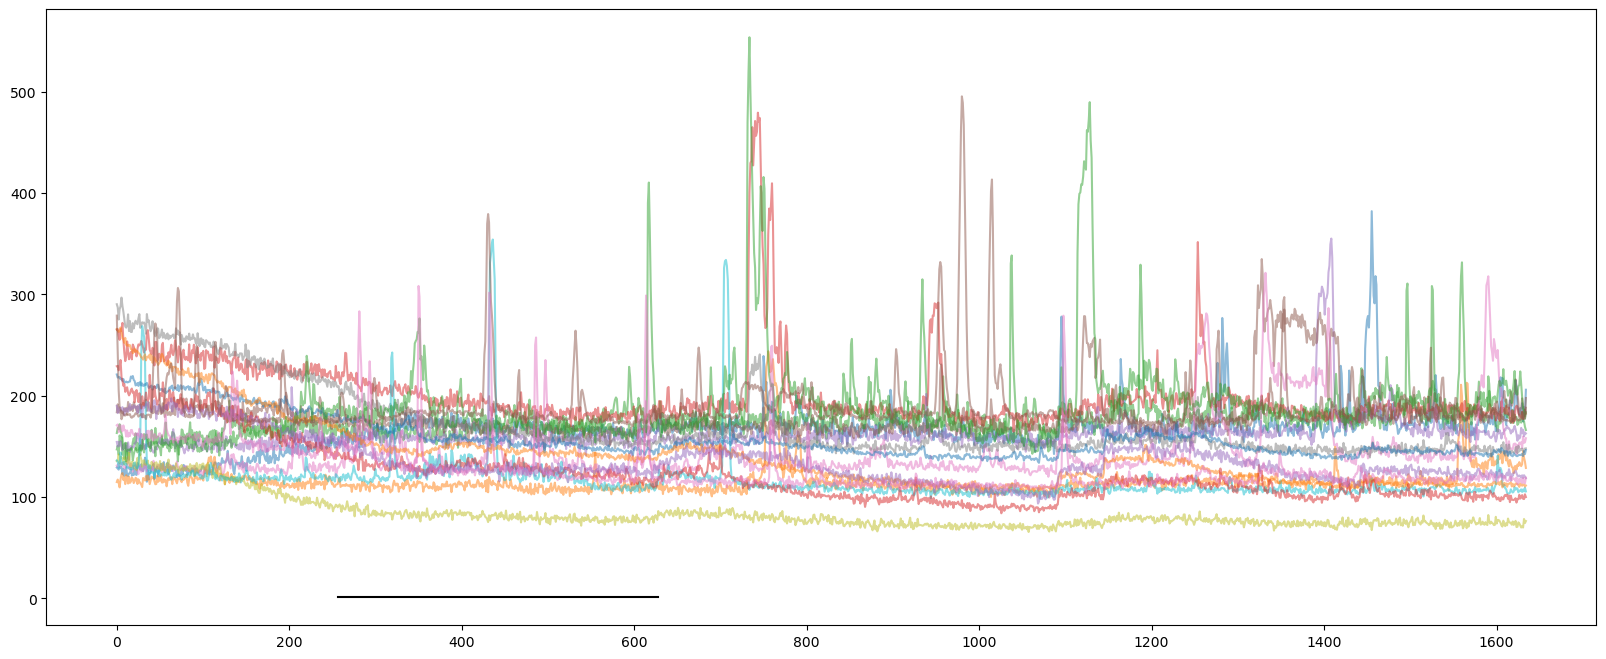

In [5]:
# plotting
plt.figure(figsize=(20, 8))
for one_prof in norm_profiles:
    plt.plot(time_line, one_prof[1], alpha=.5)
plt.plot(app_line, [1.1] * len(app_line), label='App. time', color='k')
plt.hlines(y=.5, xmin=0, xmax=np.max(time_line), linestyles='--', color='k')
plt.show()

plt.figure(figsize=(20, 8))
for one_prof in norm_profiles:
    plt.plot(time_line, one_prof[0], alpha=.5)
plt.plot(app_line, [1.1] * len(app_line), label='App. time', color='k')
plt.show()

## Peaks detection with find_peaks only

#### Selected component peaks features plotting

In [ ]:
one_comp_profile = norm_profiles[6]

comp_profile = one_comp_profile[1]#[300:800]
time_line_demo = time_line#[300:800]

# detection
peaks, properties = signal.find_peaks(comp_profile,
                                      height=None,
                                      threshold=None,
                                      distance=min_distance_frames,
                                      wlen=50,
                                      prominence=0.12,
                                      rel_height=0.5,
                                      width=width_frames,
                                      plateau_size=plat_frames)
prom = properties['prominences']
# print(properties)

# plotting
prom_h = comp_profile[peaks] - prom
width_w = np.sort(np.asarray([*properties['left_bases'], *properties['right_bases']], dtype=int))
width_pairs =  np.asarray(list(zip(properties['left_bases'], properties['right_bases'])), dtype=int)

app_y = [np.max(comp_profile)+np.max(comp_profile)*0.05] * len(app_line)

plt.figure(figsize=(20, 8))
plt.plot(time_line_demo, comp_profile)
plt.plot(time_line_demo[peaks], comp_profile[peaks], 'x', color='red')
plt.plot(time_line_demo[width_w], comp_profile[width_w], '.', color='red')
plt.plot(app_line, app_y, label='App. time', color='k')
plt.vlines(x=time_line_demo[peaks], ymin=prom_h, ymax=comp_profile[peaks], color='red')

for peak_width in width_pairs:
    plt.fill_between(
            x= time_line_demo[peak_width[0]:peak_width[1]], 
            y1= comp_profile[peak_width[0]:peak_width[1]], 
            color= "red",
            alpha= 0.2)

    
plt.legend()
plt.show()

#### All-components peaks detection & features data frame creation

In [ ]:
# peaks features data frame init
pf_df = pd.DataFrame(columns=['sample',          # sample name
                              'comp',            # spatial component ID
                              'app_group',       # application group, before/after bath application
                              'peak_num',        # peak number in profile
                              'peak_i',          # peal index in profile, frames
                              'peak_time',       # peak time, sec
                              'rise',            # rise time, sec
                              'decay',           # decay time, sec
                              'FWHM',            # full width at half maximum, sec
                              'amp_abs',         # absolute amplitude, a.u.
                              'prom_abs',        # prominence from raw profile, a.u.
                              'integral_abs',    # signal integral in rise-decay window by raw profile
                              'amp_dF',          # relative amplitude, ΔF/F
                              'integral_dF',     # signal integral in rise-decay window by relative profile, ΔF/F
                              'amp_norm',        # normalize amplitude, 0-1 range
                              'prom_norm',       # prominence from normalized profile, 0-1 range
                              'integral_norm'])  # signal integral in rise-decay window by normalized profile            

components_ID = np.array(total_df.comp.unique())
for component_num in [0]:  # range(norm_profiles.shape[0]):
    comp_ID = components_ID[component_num]

    comp_raw_profile = norm_profiles[component_num][0]
    comp_norm_profile = norm_profiles[component_num][1]

    comp_peaks, comp_properties = signal.find_peaks(comp_norm_profile,
                                                    height=None,
                                                    threshold=None,
                                                    distance=min_distance_frames,
                                                    wlen=50,
                                                    prominence=0.12,
                                                    rel_height=0.5,
                                                    width=width_frames,
                                                    plateau_size=plat_frames)
                                                    
    prom_raw = signal.peak_prominences(comp_raw_profile, comp_peaks, wlen=100)[0]

    for peak_i in range(len(comp_peaks)):
        # features calc
        peak_index = comp_peaks[peak_i]
        peak_time = time_line[peak_index]
        if peak_time < app_start_t:
            app_group = 'before'
        else:
            app_group = 'after'

        # high features section
        amp_abs = comp_raw_profile[peak_index]
        amp_norm = comp_norm_profile[peak_index]

        prom_abs = prom_raw[peak_i]
        prom_norm = comp_properties['prominences'][peak_i]

        # time features section
        rise = peak_index - comp_properties['left_bases'][peak_i]
        decay = comp_properties['right_bases'][peak_i] - peak_index

        fwhm = comp_properties['widths'][peak_i]
        
        # signal integral section
        peak_bool_mask = np.zeros_like(comp_norm_profile, dtype=bool)
        peak_bool_mask[comp_properties['left_bases'][peak_i]:comp_properties['right_bases'][peak_i]] = 1
        integral_abs = np.sum(comp_raw_profile, where=peak_bool_mask)
        integral_norm = np.sum(comp_norm_profile, where=peak_bool_mask)

        # ΔF/F section
            # NOT WORKING BECAUSE OF DOUBLE-PEAKS
            # delta_win_r_i = comp_properties['left_bases'][peak_i] - delta_win_shift
            # delta_win_l_i = delta_win_r_i - delta_win_size
            # F0_val = np.mean(comp_raw_profile[delta_win_l_i:delta_win_r_i])
            # amp_dF = (amp_abs-F0_val) / F0_val

        amp_dF = prom_abs / (amp_abs - prom_abs)
        print(amp_dF)

        peak_slice = comp_raw_profile[comp_properties['left_bases'][peak_i]:comp_properties['right_bases'][peak_i]]
        peak_dF = peak_slice / (amp_abs - prom_abs)
        print(peak_slice)
        print(peak_dF)
        integral_dF = np.sum(peak_dF)
        
    
        # data frame update
        pf_row = pd.DataFrame({'sample':[reg_name],               # sample name
                               'comp':[comp_ID],                  # spatial component ID
                               'app_group':[app_group],           # application group, before/after bath application
                               'peak_num':[peak_i],               # peak number in profile
                               'peak_i':[peak_index],             # peak index in profile, frames
                               'peak_time':[peak_time],           # peak time, sec
                               'rise':[rise * frame_time],        # rise time, sec
                               'decay':[decay * frame_time],      # decay time, sec
                               'FWHM':[fwhm * frame_time],        # full width at half maximum, sec  
                               'amp_abs':[amp_abs],               # absolute amplitude, a.u.
                               'prom_abs':[prom_abs],             # prominence from raw profile, a.u.
                               'integral_abs':[integral_abs],     # signal integral in rise-decay window from raw profile
                               'amp_dF':[amp_dF],                 # relative amplitude, ΔF/F
                               'integral_dF':[integral_dF],       # signal integral in rise-decay window by relative profile, ΔF/F
                               'amp_norm':[amp_norm],             # normalize amplitude, 0-1 range
                               'prom_norm':[prom_norm],           # prominence from normalized profile, 0-1 range
                               'integral_norm':[integral_norm]})  # signal integral in rise-decay window from normalized profile      
        pf_df = pd.concat([pf_df, pf_row], ignore_index=True)

print(pf_df.head())

## Peaks detection with custom detector

#### Convolution

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


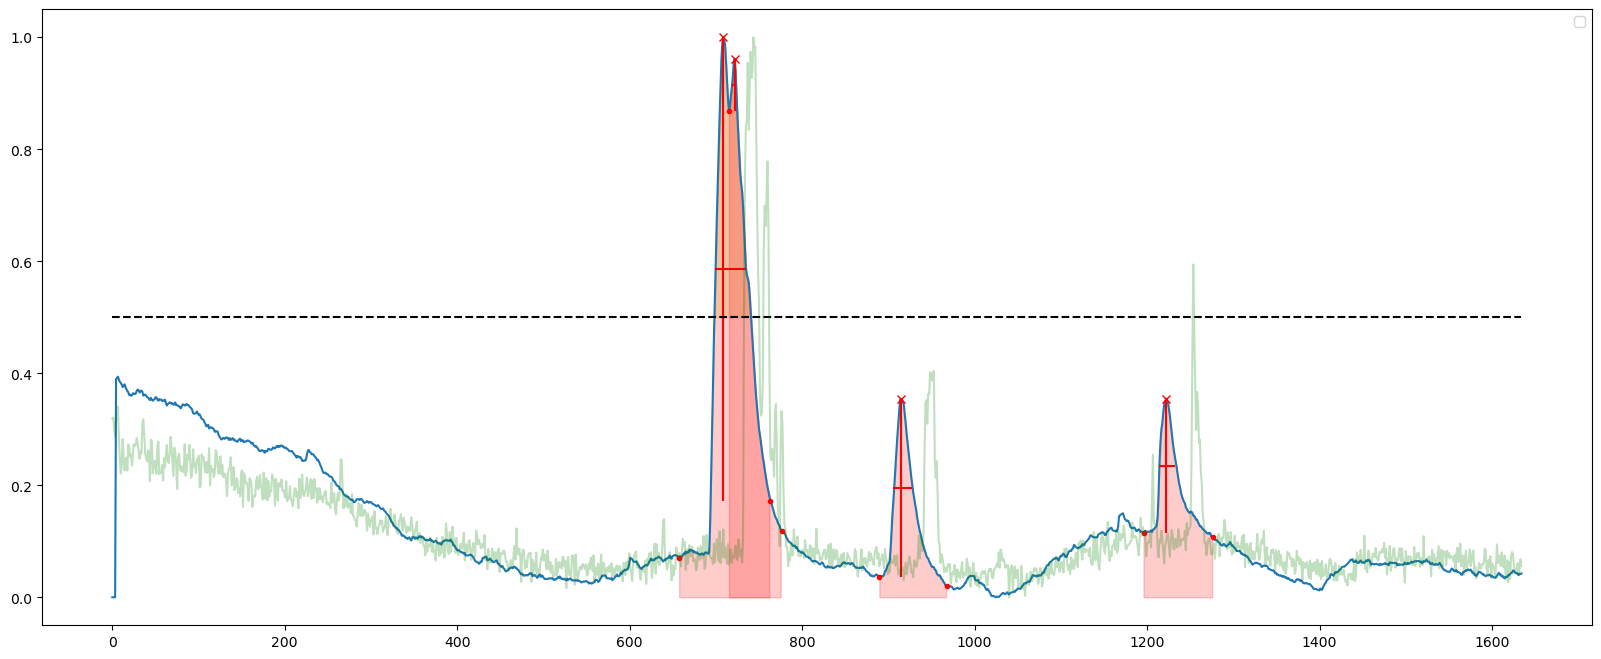

In [7]:
# kernek section
x = np.linspace(0, 10, 100)

# exp kernel
y = 1 / np.exp(np.linspace(0, 9, 90))
y = np.concatenate([np.zeros(10), y])

tau = 0.75
y_1 = 1 / np.exp(np.linspace(0, 9, 90) * tau)
y_1 = np.concatenate([np.zeros(10), y_1])

# square kernel
y_2 = np.zeros(100)
y_2[10:60] = 1


# conv section
one_comp_profile = norm_profiles[3]  # <=================================
prof_raw = one_comp_profile[0]


conv_raw = ndimage.convolve1d(prof_raw, y_1)
conv_1 = ndimage.convolve1d(prof_raw, y_1)

# scaling 0-1
prof = preprocessing.minmax_scale(prof_raw)
conv = preprocessing.minmax_scale(conv_raw)

# convolved vector shift compensation
prof_max = np.argmax(prof[:int(prof.shape[0]/4)])
conv_max = np.argmax(conv[:int(conv.shape[0]/4)])
conv_shift = prof_max - conv_max
conv = np.concatenate([np.zeros(conv_shift), conv[:-conv_shift]])

# debug plot
debug_plot = False
if debug_plot:
    # kernel plot
    plt.plot(x, y, color='b', alpha=.5, label='tau=1')
    plt.plot(x, y_1, color='r', alpha=.5, label=f'tau={tau}')
    plt.legend()
    plt.show()

    # conv plot
    plt.figure(figsize=(20, 8))
    plt.plot(prof, color='b', alpha=.25, label='raw')
    plt.plot(conv, color='r', alpha=.75, label='tau=1')

    plt.legend()
    plt.show()


# detection
peaks, properties = signal.find_peaks(conv,
                                      height=None,
                                      threshold=None,
                                      distance=min_distance_frames,
                                      wlen=100,
                                      prominence=0.05,
                                      rel_height=0.5,
                                      width=width_frames)

# print(properties)

def prof_peaks_plot(input_profile, peaks_i, peaks_prop, x_time=None, add_profile=None):
    """ SciPy find_peaks results for individual profile plotting,
    for 0-1 range scaling profile only

    """
    # features calc
    if x_time is None:
        x_time = np.linspace(0, input_profile.shape[0], input_profile.shape[0])
    prom = peaks_prop['prominences']
    prom_h = input_profile[peaks_i] - prom
    width_w = np.sort(np.asarray([*peaks_prop['left_bases'], *peaks_prop['right_bases']], dtype=int))
    width_pairs =  np.asarray(list(zip(peaks_prop['left_bases'], peaks_prop['right_bases'])), dtype=int)
    fwhm_y = peaks_prop['width_heights']
    fwhm_l = x_time[np.asarray(peaks_prop['left_ips'], dtype=int)]
    fwhm_r = x_time[np.asarray(peaks_prop['right_ips'], dtype=int)]

    # plotting
    plt.figure(figsize=(20, 8))
    plt.plot(x_time, input_profile)
    plt.plot(x_time[peaks_i], input_profile[peaks_i], 'x', color='red')
    plt.plot(x_time[width_w], input_profile[width_w], '.', color='red')
    plt.vlines(x=x_time[peaks_i], ymin=prom_h, ymax=input_profile[peaks_i], color='red')
    plt.hlines(y=fwhm_y, xmin=fwhm_l, xmax=fwhm_r, color='red')
    plt.hlines(y=.5, xmin=0, xmax=np.max(x_time), linestyles='--', color='k')
    plt.fill_between(x=x_time,
                     y1=input_profile,
                     y2=.5,
                     color='y',
                     alpha=.2,
                     where=input_profile>=.5)
    for peak_width in width_pairs:
        plt.fill_between(x= x_time[peak_width[0]:peak_width[1]], 
                         y1= input_profile[peak_width[0]:peak_width[1]], 
                         color= "red",
                         alpha= 0.2)
    if add_profile is not None:
        plt.plot(x_time, add_profile, color='g', alpha=.25)
    plt.legend()
    plt.show()

prof_peaks_plot(input_profile=conv, peaks_i=peaks, peaks_prop=properties, x_time=time_line, add_profile=prof)

#### Platau peaks merging

In [54]:
# print(peaks)
# print(list(properties.keys()))
# print(properties)

print(conv[properties['left_bases']])
print(conv[properties['right_bases']])

bases_arr = np.asarray([conv[properties['left_bases']],conv[properties['right_bases']]]).T
print(bases_arr)
print(bases_arr.shape)

bad_bases = np.asarray([np.zeros(2) if all(i<0.5) else i for i in bases_arr])
# bad_bases = np.asarray([i for i in bases_arr if any(i>=0.5)])
print(bad_bases)
print(np.nonzero(bad_bases))

# fuck_bases = np.reshape(bad_bases, (bad_bases.size))
# print(fuck_bases)
# peaks_merge_th = 0.5
# new_bases = []
# for base in bases_arr:
#     if all(base < peaks_merge_th):
#         print(f'{base} good_peak')
#         continue
    
    

[0.18713088 0.59725694 0.84659039 0.30060988 0.72262397 0.83002903
 0.73116088]
[0.17903426 0.84659039 0.30060988 0.16819787 0.73723939 0.87501938
 0.10487631]
[[0.18713088 0.17903426]
 [0.59725694 0.84659039]
 [0.84659039 0.30060988]
 [0.30060988 0.16819787]
 [0.72262397 0.73723939]
 [0.83002903 0.87501938]
 [0.73116088 0.10487631]]
(7, 2)
[[0.         0.        ]
 [0.59725694 0.84659039]
 [0.84659039 0.30060988]
 [0.         0.        ]
 [0.72262397 0.73723939]
 [0.83002903 0.87501938]
 [0.73116088 0.10487631]]
(array([1, 1, 2, 2, 4, 4, 5, 5, 6, 6]), array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1]))


In [ ]:
class p_det():
    """ Detector class

    """
    def __init__(self):
        pass